![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías

#Básicas
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#Modelos
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

#Validación, calibración y desempeño
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics

In [3]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

#### 1.1 Definición de funciones manuales

In [6]:
# Celda 1
#MSE para medir el rendimiento de los modelos
def mse(y):
    return np.mean((y - y.mean())**2)


#MSE Impurity: Calcular la reducción de error
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l, y_r = y.loc[filter_l], y.loc[~filter_l]

    n_l, n_r = y_l.shape[0], y_r.shape[0]

    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)

    return mse_impurity_

# Best Split: Calcular la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [None, None, float('-inf')]

    # Para todas las varibles
    for j in features:
        col = X.iloc[:, j]

        #Manejo de variables booleanas
        if col.dtype == bool:
            col = col.astype(int)
        elif not np.issubdtype(col.dtype, np.number):
            continue

        splits = np.percentile(col, np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = mse_impurity(col, y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

#### 1.2 Función Principal

In [7]:
# Tree Grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level, min_gain, max_depth, num_pct):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree



#### 1.3 Entrenador del árbol

In [8]:
tree = tree_grow(X_train, y_train, level=0, min_gain=1e-3, max_depth=5, num_pct=10)

#### 1.4 Predicciones

In [9]:
def tree_predict(tree, x):
    if tree['split'] == -1:
        return tree['y_pred']
    j, split = tree['split']
    if x[j] < split:
        return tree_predict(tree['sl'], x)
    else:
        return tree_predict(tree['sr'], x)

y_pred_AM= X_test.apply(lambda row: tree_predict(tree, row), axis=1)


#### 1.5 Cálculo de métricas

In [10]:
rmse_AM = np.sqrt(mean_squared_error(y_test, y_pred_AM))
mae_AM = mean_absolute_error(y_test, y_pred_AM)

print(f'RMSE Árbol Manual: {rmse_AM:.2f}')
print(f'MAE Árbol Manual: {mae_AM:.2f}')

RMSE Árbol Manual: 1697.96
MAE Árbol Manual: 1267.79


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

#### 2.1 Creación de muestras de bootstrarp

In [11]:
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

#### 2.2 Definición del modelo y entrenamiento del árbol

In [12]:
# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    treereg.fit(X_train.iloc[sample, :], y_train.iloc[sample])
    y_pred.iloc[:,i] = treereg.predict(X_test)


#### 2.3 Desempeño de cada árbol

In [13]:
for i in range(n_B):
    print('Árbol ', i, 'tiene un error MSE: ', np.sqrt(mean_squared_error(y_test, y_pred.iloc[:,i])),' y un MAE: ', mean_absolute_error(y_test, y_pred.iloc[:,i]))

Árbol  0 tiene un error MSE:  2141.613353645869  y un MAE:  1605.3012605850654
Árbol  1 tiene un error MSE:  2136.3519863123465  y un MAE:  1589.8544072363356
Árbol  2 tiene un error MSE:  2122.718759132052  y un MAE:  1577.7323421862973
Árbol  3 tiene un error MSE:  2087.278992468617  y un MAE:  1569.6103493071594
Árbol  4 tiene un error MSE:  2168.518742842026  y un MAE:  1614.8178695150114
Árbol  5 tiene un error MSE:  2113.8811455834793  y un MAE:  1576.055638953041
Árbol  6 tiene un error MSE:  2127.933470769012  y un MAE:  1582.1453521939954
Árbol  7 tiene un error MSE:  2184.414847251443  y un MAE:  1606.3077848344878
Árbol  8 tiene un error MSE:  2138.1071697514985  y un MAE:  1586.4345169361045
Árbol  9 tiene un error MSE:  2132.097520859104  y un MAE:  1587.769866243264


#### 2.4 Cálculo de métricas

In [14]:
y_pred_mean = y_pred.mean(axis=1)

rmse_BaggM = np.sqrt(mean_squared_error(y_test, y_pred_mean))
mae_BaggM = mean_absolute_error(y_test, y_pred_mean)

print(f'RMSE Bagging: {rmse_BaggM:.2f}')
print(f'MAE Bagging: {mae_BaggM:.2f}')


RMSE Bagging: 1796.44
MAE Bagging: 1340.02


#### 2.5 Análisis de resultados
En este ejercicio se realizó un bagging manual con 10 árboles, cada uno de los cuales se entrenó sin calibración de parámetros. El desempeño de los 10 árboles se midió con el RMSE y el MAE.
Para el RMSE:
- El error mínimo fue de 2087.3 y el máximo de 2184.4.

Para el MAE:
- El erro mínimo fue de 1569.6 y el máximo de 1614.8.

Al tomar las predicciones como la media de las predicciones de los 10 árboles (bagging), ambas métricas de desempeño mejoran de forma considerable. El RMSE final es de 1796.4 y el MAE de 1340.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

#### 3.1 Definición del modelo y el parámetro max_features

In [15]:
n_features = X_train.shape[1]
max_features = int(np.log(n_features))

print('max_features = ', max_features)

bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, bootstrap=True, oob_score=True, max_features=max_features,
                          random_state=1)

max_features =  2


#### 3.2 Entrenamiento y predicción

In [16]:
bagreg.fit(X_train, y_train)
y_pred_Bagg = bagreg.predict(X_test)

#### 3.3 Cálculo de métricas

In [17]:
rmse_Bagg = np.sqrt(mean_squared_error(y_test, y_pred_Bagg))
mae_Bagg = mean_absolute_error(y_test, y_pred_Bagg)

print(f'RMSE Bagging con librería: {rmse_Bagg:.2f}')
print(f'MAE Bagging con librería: {mae_Bagg:.2f}')

RMSE Bagging con librería: 2671.01
MAE Bagging con librería: 2074.98


#### 3.4 Análisis de resultados
Al realizar el ejercicio con max_features = log(n_features) = 2, y sin calibración de otros parámetros, el resultado es peor que el obtenido con el bagging manual. Esto indica que la selección de max_features no es la más apropiada para el ejercicio, y que el modelo necesita más de las variables para modelar bien. La limitación de max_features usada introduce sesgo, porque hay menos información para cada árbol, y reduce la varianza.



### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

#### 4.1 Definición y entrenamiento del modelo

In [18]:
reg = RandomForestRegressor(random_state=42)

reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

#### 4.2 Predicción y evaluación del modelo

In [19]:
y_pred_RF = reg.predict(X_test)

rmse_RF = np.sqrt(mean_squared_error(y_test, y_pred_RF))
mae_RF = mean_absolute_error(y_test, y_pred_RF)

print(f'RMSE Random Forest: {rmse_RF:.2f}')
print(f'MAE Random Forest: {mae_RF:.2f}')

RMSE Random Forest: 1765.41
MAE Random Forest: 1314.42


#### 4.4 Análisis de resultados

El modelo Random Forest mostró un desempeño competitivo en comparación con los demás enfoques evaluados. Con un RMSE de 1765.4 y MAE 1314.4, supera al modelo de Bagging con max_features=2, que obtuvo los peores resultados en ambas métricas (RMSE: 2671.013; MAE: 2074.976). Si bien no logra el mejor RMSE (el Árbol Manual fue mejor con 1697.964), Random Forest ofrece un balance más sólido entre precisión (RMSE) y calidad del modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [20]:
rf_n_estimators = []
rf_max_depth = []
rf_max_features = []

#### 5.1 Calibración de n_estimators

In [21]:
# Calibramos el parámetro n_estimators
n_estimators_range = range(10, 310, 10)
for n in n_estimators_range:
    reg = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    neg_mse = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-neg_mse))
    rf_n_estimators.append(rmse)

<function matplotlib.pyplot.show(close=None, block=None)>

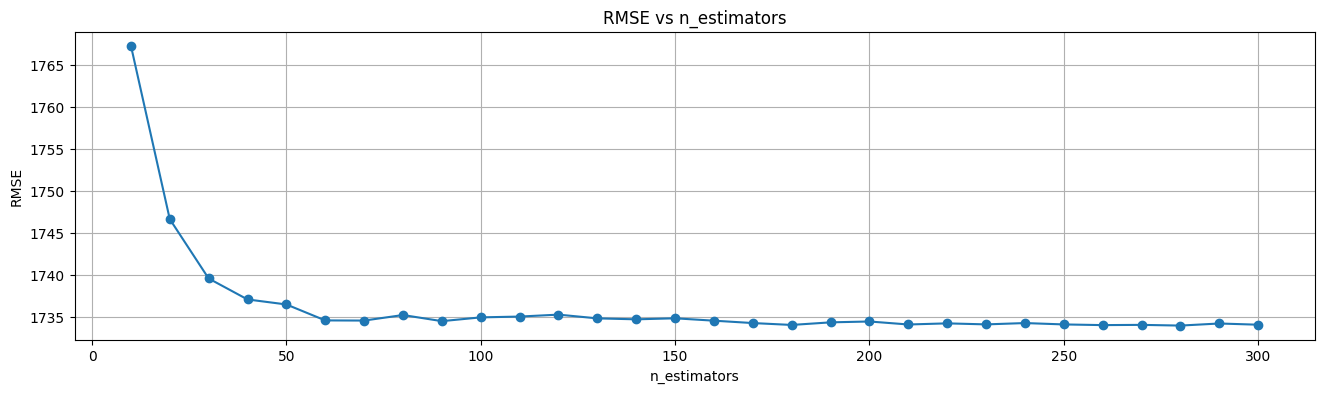

In [22]:
plt.figure(figsize=(16, 4))

plt.plot(n_estimators_range, rf_n_estimators, marker='o')
plt.title("RMSE vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.grid(True)
plt.show

In [23]:
best_index = np.argmin(rf_n_estimators)
best_n_estimators = n_estimators_range[best_index]
print('Mejor n_estimators: ', best_n_estimators)

Mejor n_estimators:  280


Aunque el valor con menos MSE es 280, se observa que después de 60 no hay altas ganancias en el MSE, por lo cual se tomará 60 como valor.

#### 5.2 Calibración de max_depth

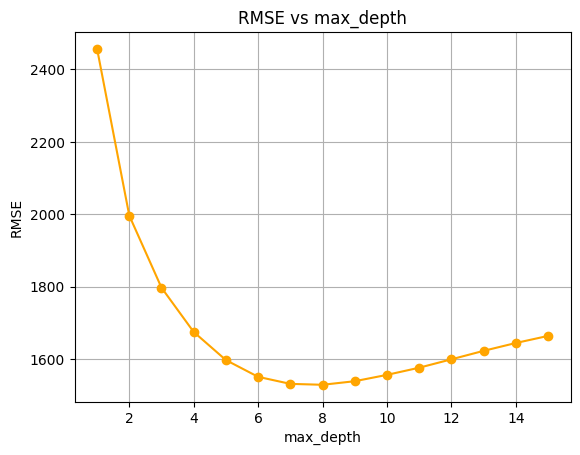

In [24]:
# Calibramos el parámetro max_depth
max_depth_range = range(1, 16)
for d in max_depth_range:
    reg = RandomForestRegressor(n_estimators=60, max_depth=d, random_state=1, n_jobs=-1)
    neg_mse = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-neg_mse))
    rf_max_depth.append(rmse)

plt.plot(max_depth_range, rf_max_depth, marker='o', color='orange')
plt.title("RMSE vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [25]:
best_index = np.argmin(rf_max_depth)
best_max_depth = max_depth_range[best_index]
print('Mejor max_depth: ', best_max_depth)

Mejor max_depth:  8


#### 5.3 Calibración de max_features

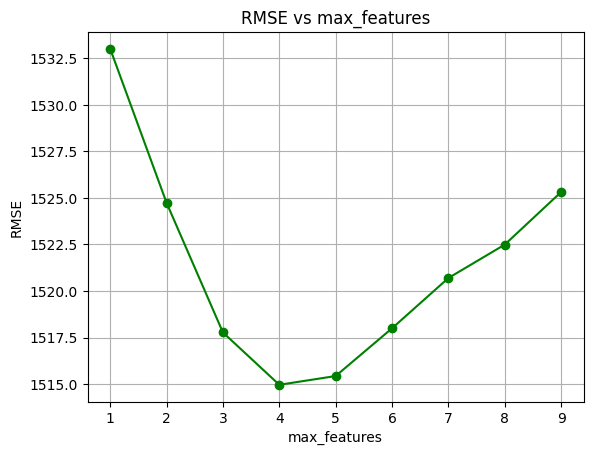

In [26]:
# Calibrar el parámetro max_features
max_features_range = range(1, X.shape[1]+1)
for f in max_features_range:
    reg = RandomForestRegressor(n_estimators=280, max_depth=8, max_features=f, random_state=1, n_jobs=-1)
    neg_mse = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(-neg_mse))
    rf_max_features.append(rmse)

plt.plot(max_features_range, rf_max_features, marker='o', color='green')
plt.title("RMSE vs max_features")
plt.xlabel("max_features")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [27]:
best_index = np.argmin(rf_max_features)
best_max_features = max_features_range[best_index]
print('Mejor max_features: ', best_max_features)

Mejor max_features:  4


#### 5.4 Definición de mejores parámetros y entrenamiento del modelo

In [29]:
modelo_final = RandomForestRegressor(
    n_estimators=60,
    max_depth=8,
    max_features=4,
    random_state=1,
    n_jobs=-1
)

#modelo_final.fit(X_trainAdj, y_trainAdj,)
modelo_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=4, n_estimators=60, n_jobs=-1,
                      random_state=1)

#### 5.5 Predicción y evaluación del modelo

In [30]:
y_pred_RF2 = modelo_final.predict(X_test)

rmse_RFAdj = np.sqrt(mean_squared_error(y_test, y_pred_RF2))
mae_RFAdj = mean_absolute_error(y_test, y_pred_RF2)

print(f'RMSE Random Forest Ajustado: {rmse_RFAdj:.2f}')
print(f'MAE Random Forest Ajustado: {mae_RFAdj:.2f}')

RMSE Random Forest Ajustado: 1552.71
MAE Random Forest Ajustado: 1141.47


#### 5.5 Análisis de resultados
Después de calibrar los hiperparámetros del modelo Random Forest (n_estimators = 280, max_depth = 8, max_features = 4), se observó una mejora significativa en su desempeño. El RMSE se redujo de 1765.4 a 1552.13 y el MAE bajó de 1314.4 a 1141.5 Esto demuestra que una adecuada selección de parámetros optimiza la capacidad predictiva del modelo y reduce tanto los errores grandes como los errores absolutos promedio.
Al analizar los gráficos de los parámetros evaluados encontramos que:
- En el primer gráfico se observa que el RMSE disminuye rápidamente hasta alrededor de 60-70 árboles, estabilizándose después de ese punto. Por eso se seleccionó 60 como un valor óptimo.
-  En el segundo gráfico se observa que el RMSE alcanza su valor mínimo cuando la profundidad máxima está entre 6 y 8 y posteriormente el RMSE empiza a crecer de nuevo; teniendo en cuenta esto se eligió 8 como un punto ideal para el modelo.
-  En el tercer gráfico el mínimo se alcanza en 4, por lo que este valor fue seleccionado para aprovechar al máximo toda la información disponible

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

#### 6.1 Definción del modelo

In [31]:
rlf = XGBRegressor()

#### 6.2 Ajuste del modelo

In [32]:
rlf.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### 6.3 Predicción del modelo y cálculo de métricas

In [33]:
y_pred_rlf = rlf.predict(X_test)

rmse_XGB = np.sqrt(mean_squared_error(y_test, y_pred_rlf))
mae_XGB = mean_absolute_error(y_test, y_pred_rlf)

print(f'RMSE XGB: {rmse_XGB:.2f}')
print(f'MAE XGB: {mae_XGB:.2f}')

RMSE XGB: 1605.24
MAE XGB: 1185.23


#### 6.4 Análisis de resultados

El modelo con XGBoost sin ajuste muestra un RMSE de 1605 y un MAE de 1185, estos valores son muy cercanos a los obtenidos al calibrar parámetros en el modelo de Random Forest; ubicando el modelo de Extreme Gradient Boosting sin ajustes en el segundo lugar por el momento, teniendo en cuenta los resultados obtenidos por ahora.  

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### 7.1 Definición del modelo

In [34]:
rlf_adj = XGBRegressor(objective='reg:squarederror', random_state=42)

#### 7.2 Definir grilla de hiperparámetros y Gridsearch

In [35]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.4],
    'colsample_bytree': [0.3, 0.5, 0.7, 1]
}

grid_search = GridSearchCV(
    estimator=rlf,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # o 'neg_mean_absolute_error'
    cv=5,
    verbose=1,
    n_jobs=-1
)

#### 7.3 Ajuste del modelo

In [36]:
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


#### 7.4 Predicción y cálculo de métricas

In [37]:
y_pred_rlf_adj = best_model.predict(X_test)


rmse_XGBAdj = np.sqrt(mean_squared_error(y_test, y_pred_rlf_adj))
mae_XGBAdj = mean_absolute_error(y_test, y_pred_rlf_adj)

print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"RMSE XGB Ajustado: {rmse_XGBAdj:.2f}")
print(f"MAE XGB Ajustado {mae_XGBAdj:.2f}")

Mejores hiperparámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05}
RMSE XGB Ajustado: 1546.23
MAE XGB Ajustado 1136.36


#### 7.5 Análisis de resultados

Al ajustar los parámetros learning rate, gamma y colsample_bytree se observa una mejora significativa de las métricas evaluadas, obteniendo un RMSE de 1546.2 y un MAE de 1136.4; resultando en un modelo con una mejor capacidad predictiva que los evaluados previamente.

El ajuste de parámetros indica que para los datos evaluados las mejores métricas se obtienen al combinar un **colsample_bytree de 0.7**, un parámetro **gamma de 0** y un **learning rate de 0.05**; lo que nos sugiere que al aumentar el gamma el desempeño del modelo puede bajar; así como la necesidad de usar valores medios en los parámetros learning rate y colsample_bytree.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [38]:
#Hacemos una tabla para visualizar los resultados
resultados = {
    "Modelo": [
        "Árbol Manual",
        "Bagging Manual",
        "Bagging Libreria",
        "Random Forest",
        "Random Forest Ajustado",
        "XG Boost",
        "XG Boost Ajustado"
    ],
    "RMSE": [rmse_AM, rmse_BaggM, rmse_Bagg, rmse_RF, rmse_RFAdj, rmse_XGB, rmse_XGBAdj
    ],
    "MAE": [mae_AM, mae_BaggM, mae_Bagg, mae_RF, mae_RFAdj, mae_XGB, mae_XGBAdj
    ]
}

df_resultados = pd.DataFrame(resultados).round(2)
df_resultados = df_resultados.sort_values(by="RMSE", ascending=True).reset_index(drop=True)
df_resultados

,Modelo,RMSE,MAE
0,XG Boost Ajustado,1546.23,1136.36
1,Random Forest Ajustado,1552.71,1141.47
2,XG Boost,1605.24,1185.23
3,Árbol Manual,1697.96,1267.79
4,Random Forest,1765.41,1314.42
5,Bagging Manual,1796.44,1340.02
6,Bagging Libreria,2671.01,2074.98


#### Análisis de resultados finales

Se entrenaron 7 modelos para predecir el precio de un automóvil, utilizando 9 variables predictoras. Al evaluar los resultados de RMSE y MAE obtenidos, se pueden destacar las siguientes conclusiones:

- El mejor desempeño se alcanzó con el modelo de **XGBoost ajustado**, en el cual se calibraron los *parámetros gamma, colsample_bytree y learning_rate* mediante búsqueda en malla (GridSearch). Este modelo obtuvo un RMSE de 1546.2 y un MAE de 1136.4, logrando así la predicción más precisa del conjunto.

- El modelo de **Bagging con max_features = log(n_features) = 2** presentó el peor desempeño. Esto sugiere que limitar en exceso la cantidad de características disponibles para cada árbol puede afectar negativamente la capacidad predictiva del modelo.

- En general, se observó que los modelos con **ajuste de hiperparámetros** superaron en desempeño a aquellos entrenados manualmente o sin calibración. Esto refuerza la importancia de ajustar los parámetros como una buena práctica para mejorar la capacidad predictiva y la precisión de los modelos de aprendizaje automático.